#### Q1) Infinite-dimensional feature space of Gaussian kernel

Exponential kernel is defined as; 

$$ K({\bf x},{\bf x}') = exp(-||{\bf x}-{\bf x}'||^2/2\sigma^2) $$

then it can be expanded; 

$$ K({\bf x},{\bf x}') = e^{-{\bf x}^T{\bf x}/2\sigma^2}e^{{\bf x}^T{\bf x}'/\sigma^2}e^{-({\bf x}')^T{\bf x}'/2\sigma^2}$$

We have the following equation for $e^{x}$ Taylor series;

$ e^x = 1 + x + \frac{x^2}{2!} + \frac {x^3}{3!} + ... $

So the middle factor of exponential kernel expansion furthure expands as; 

$$ e^{{\bf x}^T{\bf x}'/\sigma^2} = 1 + {\bf x}^T{\bf x}'/\sigma^2 + \frac{({\bf x}^T{\bf x}'/\sigma^2)^2}{2!} + \frac{({\bf x}^T{\bf x}'/\sigma^2)^3}{3!} + ...$$ 


The purpose is to show that the can be expressed as the inner product of an infinite-dimensional feature space. For the sake of simplicity I assume that ${\bf x}$ and ${\bf x}'$ are 1-D  sample point. So, I can write the equation above as dot product of two infinite vectors; 

$$ e^{{\bf x}^T{\bf x}'/\sigma^2} = [1, \frac{x}{\sigma}, \frac{x}{\sqrt{2!}\sigma^2}, \frac{x}{\sqrt{3!}\sigma^3}, ... ] \begin{bmatrix} 
    1 \\ \frac{x'}{\sigma} \\ \frac{x'}{\sqrt{2!}\sigma^2} \\ \frac{x'}{\sqrt{3!}\sigma^3}\\ \vdots
\end{bmatrix} $$

Therfore, the feature vector $\phi$ = [$\phi_1(x), \phi_2(x), ... $] has infinite elements. 
Each element of the vector can be written as; 

$$\phi_i(x) =e^{-x^2/2\sigma^2} \frac{x}{\sqrt{i!}\sigma^i} $$


In [1]:
#Import the packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit


#### Importing Data

In [2]:
testInput = pd.read_csv("nonlinear-regression-dataset/testInput.csv",sep=',',header=None).values
testTarget = pd.read_csv("nonlinear-regression-dataset/testTarget.csv",sep=',',header=None).values[:,0]

In [4]:
testInput.shape

(128, 2)

In [3]:
trainInput = []
trainTarget = []

for i in range(10):
    tmpInput = pd.read_csv("nonlinear-regression-dataset/trainInput"+str(i+1)+".csv",sep=',',header=None).values
    tmpTarget = pd.read_csv("nonlinear-regression-dataset/trainTarget"+str(i+1)+".csv",sep=',',header=None).values[:,0]
    
    for val in tmpInput:
        trainInput.append(val)
    
    for val in tmpTarget:
        trainTarget.append(val)  
        
trainInput = np.array(trainInput)
trainTarget = np.array(trainTarget)

#### Q2.a) Regularized generalized linear regression

In [4]:
#Monomial Basis Function (phi) with degree of "d" for a single 2-dimension "dataPoint" 

def monomial(d,dataPoint): 
    phi_x = []
    
    for i in range(d+1):
        for j in range((d+1)-i):
            phi_x.append(dataPoint[0]**i * dataPoint[1]**j)
    
    return np.array(phi_x)    

In [5]:
def calcPHI(d, dataSet):
    PHI_X = np.zeros([monomial(d,dataSet[0]).size, dataSet.shape[0]])
    
    for i in range(dataSet.shape[0]):
        PHI_X[:,i] = monomial(d,dataSet[i])
    
    return PHI_X  

In [6]:
def mse(predictions, targets):
    return ((predictions - targets) ** 2).mean()

Min MSE = %  0.053501872410444205
Min error happens @ degree = 4


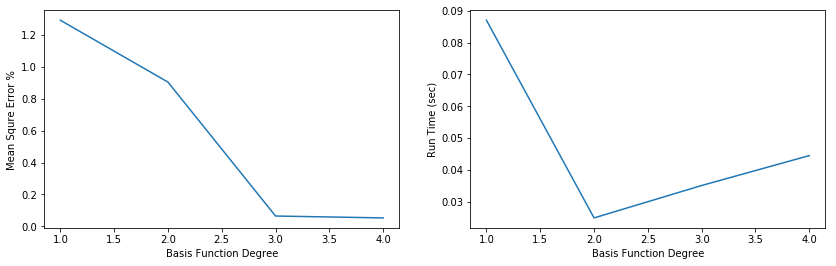

In [8]:
degree = [1,2,3,4]    #monomial Basis Function Degree

lamda = 0.5

kfolds = 10

MSE = np.zeros(len(degree))
RunTime = np.zeros(len(degree))

for i in range(len(degree)):
    
    start = timeit.default_timer()
    
    MSE_cross = np.zeros(kfolds)

    for j in range(kfolds):
        trainInput_cross = np.delete(trainInput,np.arange(j*20,(j+1)*20),0)
        trainTarget_cross = np.delete(trainTarget,np.arange(j*20,(j+1)*20),0) 
        
        validateInput = trainInput[j*20:(j+1)*20]
        validateTarget = trainTarget[j*20:(j+1)*20]
        
        PHI = calcPHI(degree[i], trainInput_cross)
        K = PHI.T.dot(PHI)
        a = np.linalg.inv(K + lamda * np.identity(K.shape[0])).dot(trainTarget_cross) 
                
        validateTarget_predict = calcPHI(degree[i], validateInput).T.dot(PHI).dot(a)
        
        MSE_cross[j] = mse(validateTarget, validateTarget_predict)
    
    stop = timeit.default_timer()
    
    RunTime[i] = stop - start
    MSE[i] = np.average(MSE_cross)
    
plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)

plt.plot(degree, MSE)
plt.xlabel('Basis Function Degree')
plt.ylabel('Mean Squre Error %');

plt.subplot(1,2,2)
plt.plot(degree, RunTime)
plt.xlabel('Basis Function Degree')
plt.ylabel('Run Time (sec)');

print ("Min MSE = % ", min(MSE))
print("Min error happens @ degree =", degree[np.argmin(MSE)])

In [9]:
PHI = calcPHI(degree[np.argmin(MSE)], trainInput)
K = PHI.T.dot(PHI)
a = np.linalg.inv(K + lamda * np.identity(K.shape[0])).dot(trainTarget) 

testTarget_predict = np.zeros(testTarget.shape[0])
        
testTarget_predict = calcPHI(degree[i], testInput).T.dot(PHI).dot(a)

MSE_test = mse(testTarget_predict, testTarget)

print("Mean Squre Error for Test Set = %", MSE_test)

Mean Squre Error for Test Set = % 0.04462350184197567


#### Q2.b) Bayesian generalized linear regression

Min MSE = % 0.04029397338595449
Min error happens @ degree = 4


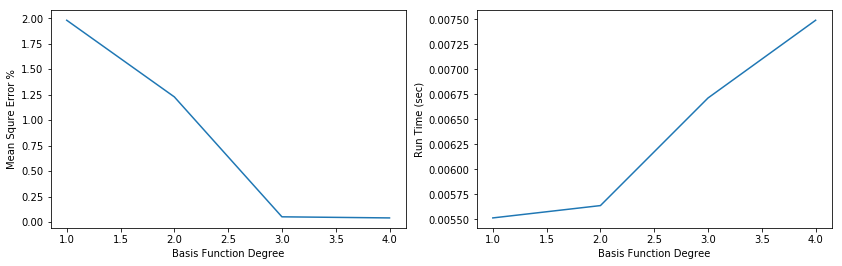

In [17]:
degree = [1, 2, 3, 4]    #monomial Basis Function Degree

kfolds = 1

MSE = np.zeros(len(degree))
RunTime = np.zeros(len(degree))

for i in range(len(degree)):
    
#     start = timeit.default_timer()
    
    MSE_cross = np.zeros(kfolds)
    time_cross = np.zeros(kfolds)
    
    for j in range(kfolds):
           
        trainInput_cross = np.delete(trainInput,np.arange(j*20,(j+1)*20),0)
        trainTarget_cross = np.delete(trainTarget,np.arange(j*20,(j+1)*20),0) 
        
        validateInput = trainInput[j*20:(j+1)*20]
        validateTarget = trainTarget[j*20:(j+1)*20]
        
        start = timeit.default_timer()
        
        PHI = calcPHI(degree[i], trainInput_cross)
        A = PHI.dot(PHI.T) + np.identity(PHI.shape[0])
        wHat = (np.linalg.inv(A).dot(PHI)).dot(trainTarget_cross) 
        
        stop = timeit.default_timer()
        
        validateTarget_predict = wHat.T.dot(calcPHI(degree[i], validateInput))
        
        MSE_cross[j] = mse(validateTarget_predict, validateTarget)
        time_cross [j] = stop-start
#     stop = timeit.default_timer()
    
    RunTime[i] = np.average(time_cross)
    MSE[i] = np.average(MSE_cross)
    
plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)

plt.plot(degree, MSE)
plt.xlabel('Basis Function Degree')
plt.ylabel('Mean Squre Error %');

plt.subplot(1,2,2)
plt.plot(degree, RunTime)
plt.xlabel('Basis Function Degree')
plt.ylabel('Run Time (sec)');

print ("Min MSE = %", min(MSE))
print("Min error happens @ degree =", degree[np.argmin(MSE)])

In [18]:
PHI = calcPHI(degree[np.argmin(MSE)], trainInput)
A = PHI.dot(PHI.T) + np.identity(PHI.shape[0])
wHat = (np.linalg.inv(A).dot(PHI)).dot(trainTarget) 

testTarget_predict = wHat.T.dot(calcPHI(degree[np.argmin(MSE)], testInput))

MSE_test = mse(testTarget_predict, testTarget)

print("Mean Squre Error for Test Set = %", MSE_test)

Mean Squre Error for Test Set = % 0.05044037782150541


#### Q2.c) Gaussian process regression

In [29]:
def identityKerCov(dataSet_1, dataSet_2):
    K = np.zeros([dataSet_1.shape[0], dataSet_2.shape[0]])
    
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            K[i][j] = dataSet_1[i].dot(dataSet_2[j])
    
    return K

In [94]:
def gaussianKerCov(sigma, dataSet_1, dataSet_2):
    K = np.zeros([dataSet_1.shape[0], dataSet_2.shape[0]])
    
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            norm = np.linalg.norm(dataSet_1[i] - dataSet_2[j])
            K[i][j] = np.exp((-norm**2) / (2*sigma**2))
    
    return K

In [122]:
def polynomialKerCoV(d, dataSet_1, dataSet_2):
    K = np.zeros([dataSet_1.shape[0], dataSet_2.shape[0]])
    
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            K[i][j] = (dataSet_1[i].dot(dataSet_2[j]) + 1)**d
    
    return K

> Identity Kernel

In [102]:
K = identityKerCov(trainInput, trainInput)
a = np.linalg.inv(K + np.identity(K.shape[0])).dot(trainTarget)
testTarget_predict = identityKerCov(testInput, trainInput).dot(a)
        
MSE_Identity= mse(testTarget_predict, testTarget)

print ("Identity Kernel MSE for Test Set = %", MSE_Identity)

Identity Kernel MSE = % 3.590620685448405


> Gaussian Kernel

Min MSE = % 0.05714877397538333
Min error happens @ sigma = 4


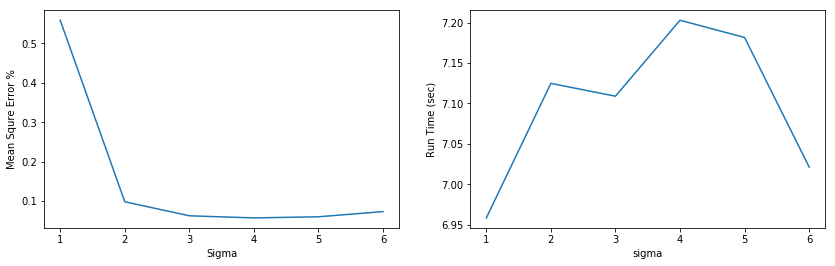

In [143]:
sigma = [1, 2, 3, 4, 5, 6]    #monomial Basis Function Degree

kfolds = 10

MSE = np.zeros(len(sigma))
RunTime = np.zeros(len(sigma))

for i in range(len(sigma)):
    start = timeit.default_timer()
    MSE_cross = np.zeros(kfolds)

    for j in range(kfolds):
        trainInput_cross = np.delete(trainInput,np.arange(j*20,(j+1)*20),0)
        trainTarget_cross = np.delete(trainTarget,np.arange(j*20,(j+1)*20),0) 
        
        validInput = trainInput[j*20:(j+1)*20]
        validTarget = trainTarget[j*20:(j+1)*20]
        
        K = gaussianKerCov(sigma[i], trainInput_cross, trainInput_cross)
        a = np.linalg.inv(K + np.identity(K.shape[0])).dot(trainTarget_cross)
        validTarget_predict = gaussianKerCov(sigma[i], validInput, trainInput_cross).dot(a)
        
        MSE_cross[j]= mse(validTarget_predict, validTarget)
        
    stop = timeit.default_timer()
    RunTime[i] = stop - start
    
    MSE[i] = np.average(MSE_cross)
    
gKer_RT = [min(RunTime), max(RunTime)]

plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)

plt.plot(sigma, MSE)
plt.xlabel('Sigma')
plt.ylabel('Mean Squre Error %');

plt.subplot(1,2,2)
plt.plot(sigma, RunTime)
plt.xlabel('sigma')
plt.ylabel('Run Time (sec)');

print ("Min MSE = %", min(MSE))
print("Min error happens @ sigma =", degree[np.argmin(MSE)])

In [144]:
K = gaussianKerCov(sigma[np.argmin(MSE)], trainInput, trainInput)
a = np.linalg.inv(K + np.identity(K.shape[0])).dot(trainTarget)
testTarget_predict = gaussianKerCov(sigma[np.argmin(MSE)], testInput, trainInput).dot(a)
        
MSE_gaussian= mse(testTarget_predict, testTarget)

print ("Gaussian Kernel MSE for Test Set = %", MSE_gaussian)

Gaussian Kernel MSE for Test Set = % 0.043025161668200265


> Polynomial Kernel

Min MSE = % 0.054368715570554796
Min error happens @ polynomial degree = 4


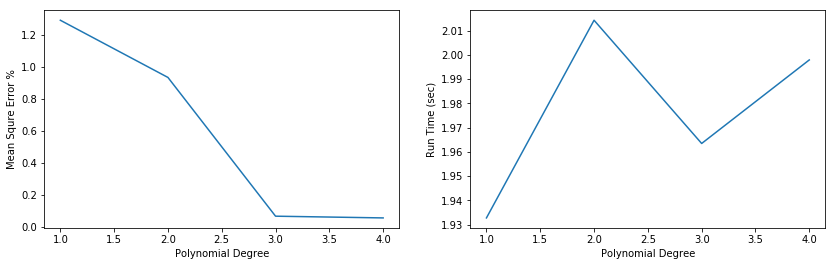

In [145]:
degree = [1, 2, 3, 4]    #monomial Basis Function Degree

kfolds = 10

MSE = np.zeros(len(degree))
RunTime = np.zeros(len(degree))

for i in range(len(degree)):
    start = timeit.default_timer()
    MSE_cross = np.zeros(kfolds)

    for j in range(kfolds):
        trainInput_cross = np.delete(trainInput,np.arange(j*20,(j+1)*20),0)
        trainTarget_cross = np.delete(trainTarget,np.arange(j*20,(j+1)*20),0) 
        
        validInput = trainInput[j*20:(j+1)*20]
        validTarget = trainTarget[j*20:(j+1)*20]
        
        K = polynomialKerCoV(degree[i], trainInput_cross, trainInput_cross)
        a = np.linalg.inv(K + np.identity(K.shape[0])).dot(trainTarget_cross)
        validTarget_predict = polynomialKerCoV(degree[i], validInput, trainInput_cross).dot(a)
        
        MSE_cross[j]= mse(validTarget_predict, validTarget)
        
    stop = timeit.default_timer()
    RunTime[i] = stop - start
    
    MSE[i] = np.average(MSE_cross)
    
pKer_RT = [min(RunTime), max(RunTime)]

plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)

plt.plot(degree, MSE)
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squre Error %');

plt.subplot(1,2,2)
plt.plot(degree, RunTime)
plt.xlabel('Polynomial Degree')
plt.ylabel('Run Time (sec)');

print ("Min MSE = %", min(MSE))
print("Min error happens @ polynomial degree =", degree[np.argmin(MSE)])

In [146]:
K = polynomialKerCoV(degree[np.argmin(MSE)], trainInput, trainInput)
a = np.linalg.inv(K + np.identity(K.shape[0])).dot(trainTarget)
testTarget_predict = polynomialKerCoV(degree[np.argmin(MSE)], testInput, trainInput).dot(a)
        
MSE_poly= mse(testTarget_predict, testTarget)

print ("Polynomial Kernel MSE for Test Set = %", MSE_poly)

Polynomial Kernel MSE for Test Set = % 0.04576775190620877


Run Time of guassian kernel is in the order of 7 sec and of polynomial kelrnel is in the order of 2 sec.
That is, the polynomial kelrnel is more than 3 times faster than guassian kernel.

In [147]:
print("Guaussian Kernel Run Time [min, max]: ", gKer_RT)
print("Polynomial Kernel Run Time [min, max]: ", pKer_RT)

Guaussian Kernel Run Time [min, max]:  [6.958495100003347, 7.2028459000030125]
Polynomial Kernel Run Time [min, max]:  [1.9327310000007856, 2.014246099999582]


#### Q2.d) Neural network

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
#set early stopping monitor so the model stops training when it won't improve anymore
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


C:\Users\Mehdi Abbasi Azad\Anaconda3\envs\tensorflow_env\lib\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


0
1
2
3
4
5
6
7
8
9
Min MSE =  0.4286984536163859
Min error happens @ number of hidden Units= 5


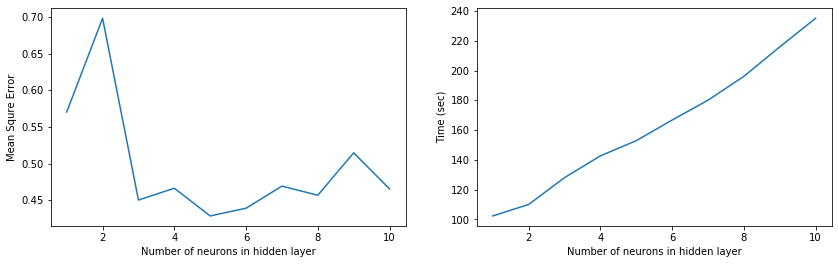

In [6]:
kfolds = 10 

hiddenUnitsNo = np.arange(1,11)

MSE = np.zeros(len(hiddenUnitsNo))
RunTime = np.zeros(len(hiddenUnitsNo))

for i in range(len(hiddenUnitsNo)):

    start = timeit.default_timer()

    MSE_cross = np.zeros(kfolds)

    for j in range(kfolds):
        trainInput_cross = np.delete(trainInput,np.arange(j*20,(j+1)*20),0)
        trainTarget_cross = np.delete(trainTarget,np.arange(j*20,(j+1)*20),0) 
        
        validateInput = trainInput[j*20:(j+1)*20]
        validateTarget = trainTarget[j*20:(j+1)*20]
    
        model = Sequential()
        model.add(Dense(i+1, activation="sigmoid", input_shape=(trainInput_cross.shape[1],)))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')

        early_stopping_monitor = EarlyStopping(patience=3)
        #train model
        model.fit(trainInput_cross, trainTarget_cross, epochs=1000, callbacks=[early_stopping_monitor], verbose=0)

        validatePredictions = model.predict(validateInput)
        
        MSE_cross[j] = mse(validatePredictions, validateTarget)
        
    stop = timeit.default_timer()
    
    print(i)
    
    RunTime[i] = stop - start
    MSE[i] = np.average(MSE_cross)
    
plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)

plt.plot(hiddenUnitsNo, MSE)
plt.xlabel('Number of neurons in hidden layer')
plt.ylabel('Mean Squre Error %');

plt.subplot(1,2,2)
plt.plot(hiddenUnitsNo, RunTime)
plt.xlabel('Number of neurons in hidden layer')
plt.ylabel('Run Time (sec)');

print ("Min MSE = %", min(MSE))
print("Min error happens @ number of hidden Units=", hiddenUnitsNo[np.argmin(MSE)]);

In [8]:
model = Sequential()
model.add(Dense(5, activation="sigmoid", input_shape=(trainInput.shape[1],)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping_monitor = EarlyStopping(patience=3)
model.fit(trainInput, trainTarget, epochs=1000, callbacks=[early_stopping_monitor], verbose=0)

testPredictions = model.predict(testInput)
        
MSE_test = mse(testPredictions, testTarget)
print ("MSE test set = %", MSE_test)

MSE test set % =  0.358587174952526
